# Calculating monthly averages and other summaries from daily projections from Cal-Adapt API

Begin by importing all python modules we will need.

In [1]:
# A 'magic' command that displays plots inline inside the notebook as static images
%matplotlib inline

import requests 
import numpy as np
import pandas as pd
from datetime import datetime

Defining some functions and values that we use later in the code. 

In [2]:
# Convert value from degrees Celsius to degrees Fahrenheit (used for observed data)
def celsius_to_F(val):
    return val * 9/5 + 32 

# Convert value from Kelvin to degrees Fahrenheit (used for modeled data)
def kelvin_to_F(val):
    return  (val - 273.15) * 9/5 + 32

# Request header
headers = {'ContentType': 'json'}

### You can get data for a point or an area of your interest

If you are requesting data for a point or polygon use the `g` parameter to specify geometry. Geometry can be written in various formats including WKT, GeoJSON, KML. The examples below use WKT (Well Known Text) format.

In [3]:
# Uncomment the following lines to get data for a point location
#point = 'POINT(-121.4687 38.5938)'
#params = {'g': point}

# Uncomment the following lines to get data for a polygon
#polygon = 'POLYGON ((-123.35449 39.09596, -122.27783 39.09596, -122.27783 39.97712, -123.35449 39.97712, -123.35449 39.09596))' 
#params = {'g': polygon, 'stat': 'mean'}

### If you want to use polygon geometry from Cal-Adapt API, it's a 2-step process

- First get a polygon from a boundary layer in the API (e.g. counties, census tracts, place, etc.) that intersects your point of interest. Build a string that references the id of the polygon.
- Then use the `ref` param instead of the `g` param to request data

[Complete list of boundaries in Cal-Adapt API](https://berkeley-gif.github.io/caladapt-docs/data-catalog.html#vector-data). **Note: Requests might time out if the polygon is too large**. Subsetting the daily data has been tested with counties, census tracts, places and hydrounits. If you need data for a large boundary we reccomend downloading the daily rasters and processing the data locally. 

In [4]:
# Your point of interest
point = 'POINT(-121.4687 38.5938)'
# Name of boundary layer in API
resource = 'counties'
# Request url
url = 'http://api.cal-adapt.org/api/%s/' % resource
# Request params to find intersecting boundaries
params = {'intersects': point, 'srs': 4326, 'simplify': .0001, 'precision': 4}
ref = ''

# Get geometry
response = requests.get(url, params=params, headers=headers)
if response.ok:
    data = response.json()
    feature = data['features'][0]
    if (feature):
        ref = '/api/%s/%s/' % (resource, feature['id'])
        print(ref)
    else:
        print('Did not find any polygons that intersect your point')

params = {'ref': ref, 'stat': 'mean'}

/api/counties/34/


## 1. Get daily data

For this example we will get modeled projections for one scenario (RCP 8.5) and one model (HadGEM2-ES) for a county boundary in the Cal-Adapt API (see `params` in the previous code block).

In [5]:
# Request url
url = 'http://api.cal-adapt.org/api/series/tasmax_day_HadGEM2-ES_rcp85/' + 'rasters/'

# Make request
response = requests.get(url, params=params, headers=headers)

# Variable stores modeled daily data in a Pandas dataframe
df = None

if response.ok:
    json = response.json()
    data = json['results'][0]
    
    # Multiband raster data is returned by the API as a 3D array having a shape (233376, 1, 1)
    # Flatten the 3D array into a 1D array
    values_arr = np.array(data['image'])
    values_arr = values_arr.flatten()
    
    # Get start date of timeseries
    start_date = datetime.strptime(data['event'], '%Y-%m-%d')
    
    # Get total number of values -> number of days
    length = len(values_arr)
    
    # Create new pandas dataframe and map each value in list to a date index
    df = pd.DataFrame(values_arr,
        index=pd.date_range(start_date, freq='1D', periods=length),
        columns=['value'])
    
    # Convert Kelvin to Fahrenheit
    df.value = df.value.apply(lambda x: kelvin_to_F(x))

Print the first and last 5 values of the daily timeseries

In [6]:
print(df.head())
print()
print(df.tail())

                value
2006-01-01  54.075602
2006-01-02  51.549680
2006-01-03  51.462877
2006-01-04  51.992432
2006-01-05  45.609325

                value
2099-12-27  56.904231
2099-12-28  61.793922
2099-12-29  61.170569
2099-12-30  62.885722
2099-12-31  64.597578


### 2. Calculate annual averages from daily timeseries

In [7]:
df.value.resample('1AS').mean()

2006-01-01    74.940755
2007-01-01    78.062283
2008-01-01    75.513896
2009-01-01    75.522799
2010-01-01    74.213921
2011-01-01    76.076347
2012-01-01    76.867439
2013-01-01    76.582322
2014-01-01    76.598499
2015-01-01    74.755401
2016-01-01    76.388079
2017-01-01    77.075282
2018-01-01    75.074902
2019-01-01    76.852992
2020-01-01    78.881004
2021-01-01    76.545227
2022-01-01    79.619940
2023-01-01    78.296650
2024-01-01    76.994133
2025-01-01    77.551377
2026-01-01    78.296732
2027-01-01    77.240043
2028-01-01    78.353793
2029-01-01    77.749436
2030-01-01    76.343695
2031-01-01    76.771049
2032-01-01    79.227882
2033-01-01    77.548279
2034-01-01    79.993947
2035-01-01    78.555741
                ...    
2070-01-01    83.843379
2071-01-01    81.675994
2072-01-01    83.960937
2073-01-01    81.763037
2074-01-01    81.878724
2075-01-01    82.892739
2076-01-01    83.425516
2077-01-01    83.217695
2078-01-01    83.340424
2079-01-01    83.934939
2080-01-01    83

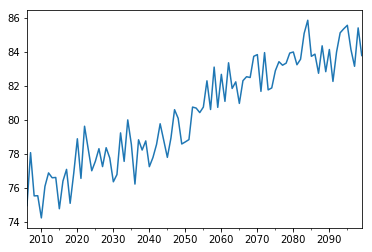

In [8]:
df.value.resample('1AS').mean().plot()

### 3. Calculate monthly averages from daily timeseries

In [9]:
monthly_avg = df.value.resample('MS').mean()
monthly_avg

2006-01-01     55.908003
2006-02-01     64.956621
2006-03-01     67.036066
2006-04-01     77.682815
2006-05-01     79.368712
2006-06-01     82.762550
2006-07-01     93.973568
2006-08-01     92.006714
2006-09-01     91.265109
2006-10-01     75.086864
2006-11-01     63.915263
2006-12-01     54.872271
2007-01-01     51.811407
2007-02-01     64.152211
2007-03-01     68.536818
2007-04-01     78.953530
2007-05-01     85.376784
2007-06-01     96.497335
2007-07-01    100.102504
2007-08-01     99.149998
2007-09-01     89.435285
2007-10-01     75.208942
2007-11-01     64.862380
2007-12-01     61.878563
2008-01-01     57.405202
2008-02-01     63.789031
2008-03-01     66.629260
2008-04-01     73.182721
2008-05-01     79.566522
2008-06-01     90.628852
                 ...    
2097-07-01    101.427537
2097-08-01    100.988321
2097-09-01     97.522921
2097-10-01     88.978502
2097-11-01     73.268641
2097-12-01     65.744710
2098-01-01     60.939684
2098-02-01     66.752057
2098-03-01     74.747442


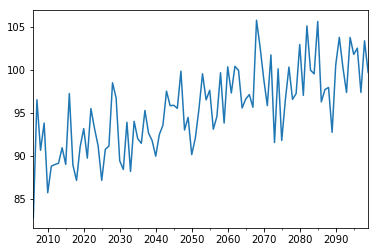

In [10]:
jun_avg = monthly_avg[monthly_avg.index.month == 6]
jun_avg.plot()

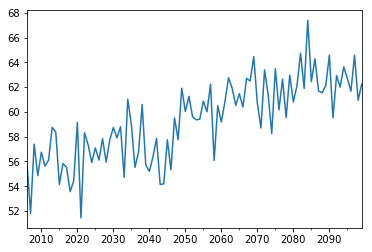

In [11]:
jan_avg = monthly_avg[monthly_avg.index.month == 1]
jan_avg.plot()

### 4. Export dataframe to csv file

In [12]:
monthly_avg.to_csv('monthly_avg.csv')